<a href="https://colab.research.google.com/github/ego-alt/segmentation-from-scratch/blob/master/cell_image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget https://cildata.crbs.ucsd.edu/ccdb//telescience/home/CCDB_DATA_USER.portal/P2043/Experiment_6835/Subject_6837/Tissue_6840/Microscopy_6843/MP6843_img_full.zip
!wget https://cildata.crbs.ucsd.edu/ccdb//telescience/home/CCDB_DATA_USER.portal/P2043/Experiment_6835/Subject_6837/Tissue_6840/Microscopy_6843/MP6843_seg.zip
!unzip -o -d ./images MP6843_img_full.zip
!unzip -o -d ./labels MP6843_seg.zip
!rm *.zip

In [2]:
from os.path import join
from os import listdir
import numpy as np
import cv2
import torch
from torch import nn, optim, float
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import matplotlib.pyplot as plt

In [3]:
im_root, lb_root = "./images", "./labels"
im_files = [join(im_root, im) for im in sorted(listdir(im_root)) if 'w1' in im]
lb_files = [join(lb_root, lb) for lb in sorted(listdir(lb_root)) if '_01' in lb]
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
dim = (696, 520)
images = [cv2.resize(cv2.imread(img), dim, interpolation = cv2.INTER_AREA) for img in im_files]
images = np.array(images)

In [5]:
labels = [cv2.imread(lbl,0) for lbl in lb_files]
labels = (np.array(labels)/255)

In [6]:
class CellImages(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.CenterCrop(256),
        ])
        self.img = [self.transform(i).to(device) for i in self.images]
        self.lbl = [self.transform(j).to(device) for j in self.labels]
    
    def __len__(self):
        return len(self.images)

    def __getitem__(self, ind):
        img = self.img[ind]
        lbl = self.lbl[ind]
        return img, lbl

In [7]:
train = DataLoader(CellImages(images[0:70], labels[0:70]), batch_size=5, shuffle=False)
test = DataLoader(CellImages(images[70:90], labels[70:90]), batch_size=5, shuffle=False)

In [8]:
def show_cuda_image(runs, *args):
    for ind in range(runs):
        i = 0
        f, ax = plt.subplots(1,len(args), figsize=(10,10))
        for arg in args:
            ax[i].imshow(arg[ind].cpu().numpy()[0])
            ax[i].grid()
            i = i + 1
    plt.show()

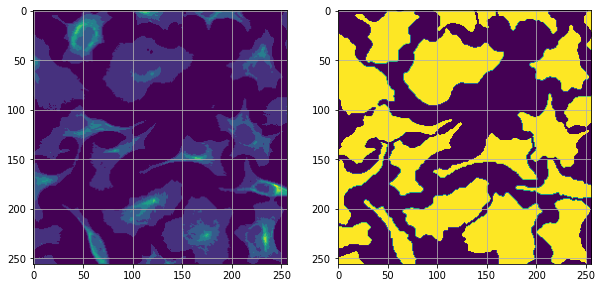

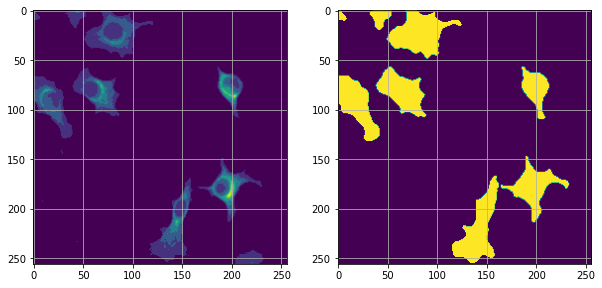

In [9]:
for i, sample in enumerate(train):
    if i == 3:
        img, lbl = sample
        show_cuda_image(2, img, lbl)
        break

In [10]:
class Block(nn.Module):
    def __init__(self, in_channel, out_channel):
        super().__init__()
        self.stack = nn.Sequential(
            nn.Conv2d(in_channel, out_channel, (3, 3), bias=False),
            nn.BatchNorm2d(out_channel),
            nn.ReLU(),
            nn.Conv2d(out_channel, out_channel, (3, 3),  bias=False),
            nn.BatchNorm2d(out_channel),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.stack(x)
        return x

In [11]:
class UNet(nn.Module):
    def __init__(self, channels, output_size, final_output=1):
        super(UNet, self).__init__()
        self.down, self.up = channels, [c for c in reversed(channels[1:])]  # Number of feature channels
        self.down_layers, self.up_layers = nn.ModuleList(), nn.ModuleList()
        self.output_size = output_size
        self.build_layers(final_output)  # Generate list of required modules
        self.features = []

    def forward(self, x):
        output = self.expansive(self.contracting(x))
        output = F.interpolate(output, self.output_size)
        return output

    def build_layers(self, final):
        # Generate sequence layer for the expansive & contracting path
        for i in range(len(self.down) - 1):
            self.down_layers.append(Block(self.down[i], self.down[i + 1]))
            if i != max(range(len(self.down) - 1)):
                self.down_layers.append(nn.MaxPool2d((2, 2), stride=2))  # 2x2 max pooling
                self.up_layers.append(nn.ConvTranspose2d(self.up[i], self.up[i + 1], (2, 2), stride=2))
                self.up_layers.append(Block(self.up[i], self.up[i + 1]))
            else:
                self.up_layers.append(nn.Conv2d(self.up[-1], final, (1, 1)))  # 1x1 convolutional layer

    def contracting(self, model):
        """3x3 convolutions & ReLU followed by 2x2 max pooling for downsampling"""
        for i in range(0, len(self.down_layers) - 1, 2):
            block = self.down_layers[i](model)
            self.features.append(block)  # Store block outputs for concatenation
            model = self.down_layers[i + 1](block)
        model = self.down_layers[-1](model)
        return model

    def expansive(self, model):
        """Upsampling followed by 3x3 convolutions & ReLU"""
        for i in range(0, len(self.up_layers) - 1, 2):
            block = self.up_layers[i](model)
            feature = self.crop(self.features[::-1][int(i / 2)], block)
            block = torch.cat([block, feature], dim=1)  # Double the number of feature channels
            model = self.up_layers[i + 1](block)
        model = self.up_layers[-1](model)
        return model

    def crop(self, feature, block):  # Necessary due to loss of border pixels every convolution
        _, _, h, w = block.shape
        feature = transforms.CenterCrop([h, w])(feature)
        return feature

In [12]:
def train_loop(dataloader, model, loss_fn, optimizer):
    """Training batch to update weights and biases"""
    size = len(dataloader.dataset)

    for i, (img, lbl) in enumerate(dataloader):
        img_batch, lbl_batch = img.float(), lbl
        pred = model(img_batch)
        loss = loss_fn(pred, lbl_batch)

        # Backpropagation to adjust the weights and biases
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        loss_val, current = loss.detach().item(), (i + 1) * len(img_batch)
        print(f"loss: {loss_val:>7f}  [{current:>5d}/{size:>5d}]")

In [13]:
def test_loop(dataloader, model, loss_fn):
    "Validation batch for each epoch"
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss = 0
    x, y = output_size

    with torch.no_grad():
        for (img, lbl) in dataloader:
            img_batch, lbl_batch = img, lbl
            pred = model(img_batch.float())
            loss = loss_fn(pred, lbl_batch)

            test_loss += loss.detach().item()
            out = (nn.Sigmoid()(pred) > 0.5).float()
            correct = (torch.eq(out, lbl_batch).sum() / out.numel())

    test_loss /= num_batches
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return img_batch, out, lbl_batch

In [14]:
output_size = (256, 256)
channels = [3, 64, 128]
handler = UNet(channels, output_size).to(device)
loss_fn = nn.BCEWithLogitsLoss()
epochs = 10
optimiser = optim.Adam(handler.parameters(), lr=3e-4)
scheduler = optim.lr_scheduler.OneCycleLR(optimiser, max_lr=5e-3, steps_per_epoch=len(train), epochs=epochs)

In [ ]:
for t in range(epochs):
    print(f"Epoch {t + 1}\n-------------------------------")
    train_loop(train, handler, loss_fn, optimiser)
    test_loop(test, handler, loss_fn) 
print("Done!")

In [ ]:
unseen = DataLoader(CellImages(images[95:100], labels[95:100]), batch_size=5, shuffle=False)
inp, pred, ans = test_loop(unseen, handler, loss_fn)
show_cuda_image(5, inp, pred, ans)

In [ ]:
torch.cuda.memory_stats()